In [5]:
########################start##############################
import pandas as pd
df=pd.read_csv('./datas/Data_MergeNew.csv',index_col=0)
df.index=pd.to_datetime(df.date,format='%Y-%m-%d') 
df.drop('date',axis=1,inplace=True)
df_train=df.loc['2020-01-07':'2021-04-02'] 
df_test=df.loc['2021-04-02':'2021-04-23']

name=['cityin','cityto','incity','city']
name1=['cityin','cityto','incity']
x_train=df_train.drop(name,axis=1).values  
y_train=df_train[name1].values
x_test=df_test.drop(name,axis=1).values  
y_test=df_test[name1].values
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

#####################标准化##############################
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(x_train)
x_train = ss.transform(x_train) 
x_test = ss.transform(x_test)

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,4,6,8,20,21,23,25,34,36,38,40,56,59,60,63,64,65,67,69) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(53370, 65) (17755, 65) (53370, 3) (17755, 3)


In [6]:
import csv
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei',font_scale=1.5)  # 解决Seaborn中文显示问题并调整字体大小
sns.set_style("white")
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)            
        print("---  new folder...  ---")
        print("---  OK  ---")
    else:
        print("---  There is this folder!  ---")
mkdir("./results_merge/")        
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error,r2_score,mean_squared_log_error

def calculate(y_true, y_predict, n, p):
    y_true = y_true
    y_predict = y_predict
    mse = mean_squared_error(y_true, y_predict)
    rmse = np.sqrt(mean_squared_error(y_true, y_predict))
    mae = mean_absolute_error(y_true, y_predict)
    r2 = r2_score(y_true, y_predict)
    mad = median_absolute_error(y_true, y_predict)
    mape = np.mean(np.abs((y_true - y_predict) / y_true)) * 100
    r2_adjusted = 1-((1-r2)*(n-1))/(n-p-1)
    # print('MSE: ', mse)
    # print('RMSE: ', rmse)
    # print('MAE: ', mae)
    # print('R2: ', r2)
    # print('MAD:', mad)
    # print('MAPE:', mape)
    # print('R2_Adjusted: ',r2_adjusted)
    return mse,rmse,mae,r2,mad,mape,r2_adjusted
# 将参数和评估结果写入文件
def write_csv_result(path_1,path_2,all_metrics,all_parameter):
    with open(path_1,"a",encoding="utf-8",newline="")as f:
        f = csv.writer(f)
        f.writerow(all_metrics)
    with open(path_2,"a",encoding="utf-8",newline="")as f:
        f = csv.writer(f)
        f.writerow(all_parameter)


---  There is this folder!  ---


In [7]:
####################ADA算法#####################################
# from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

def adjust_ada(train_x,test_x,train_y,test_y,name):
    path_a = "./results_merge/" + "Ada_" + name + "_" + "assess.csv"
    path_p = "./results_merge/" + "Ada_" + name + "_" + "parameter.csv"
    path_b = "./results_merge/" + "Ada_" + name + "_" + "best.csv"
    model_path = "./results_merge/" + "Ada_" + name + "_" + "best.m"
    # path2 = "./results/Ada_" + name + "_new" + "assess.csv"
    # path3 = "./results/Ada_" + name + "_new" + "parameter.csv"
    # # path4 = "./results/Ada_" + name + "_newin" + "assess.csv"
    # # path5 = "./results/Ada_" + name + "_newin" + "parameter.csv"
    # # path6 = "./results/Ada_" + name + "_newto" + "assess.csv"
    # # path7 = "./results/Ada_" + name + "_newto" + "parameter.csv"
    # # path8 = "./results/Ada_" + name + "_innew" + "assess.csv"
    # # path9 = "./results/Ada_" + name + "_innew" + "parameter.csv"
    all_assessed_values = []
    all_parameter = []
    n_estimators = [50,100,200,300,400,500,600,700,800]
    learning_rate = [0.1,0.25,0.5,0.75,1]
    loss = ["linear","square","exponential"]
    criterion = ["mse"] # "mae"
    splitter = ["best","random"]
    max_features = ["None","log2","sqrt","auto"]
    max_leaf_nodes = ["None"]
    min_samples_split = [2]
    min_samples_leaf = [1]
    all_nb = len(n_estimators) * len(learning_rate) * len(loss) * len(criterion) * len(splitter) * len(max_features) * len(max_leaf_nodes) * len(min_samples_leaf) * len(min_samples_split)
    num = 1
    # 用于重启训练模型，提高效率，不重复跑相同的实验
    if(os.path.exists(path_a)):
        data = pd.read_csv(path_a)
        if(data.shape[0]>1):
            try:
                nums = int(data.values[-1,0])
            except:
                nums=0
        else:
            nums = 0
    else:
        nums = 0
        col_a = ['num','mse','rmse','mae','r2','mad','mape','r2_adjusted']
        col_p = ['num','n_estimators','learning_rate','loss','criterion','splitter','max_features','max_leaf_nodes','min_samples_leaf','min_samples_split']
        write_csv_result(path_a,path_p,col_a,col_p)
    # 用于保存最好的模型
    if(os.path.exists(path_b)):
        # best_results = pd.read_csv(path_b)
        # if(best_results.shape[0]>1):
        #     best_result = best_results["rmse"].values[-1]
        # else:
        best_result = 10*10**30
    else:
        with open(path_b,"a",encoding="utf-8",newline="")as f:
            f = csv.writer(f)
            f.writerow(['num','mse','rmse','mae','r2','mad','mape','r2_adjusted'])
        best_result = 10*10**30
    if(os.path.exists(path_a)):
        data = pd.read_csv(path_a)
        try:
            nums = int(data.values[-1,0])
        except:
            nums=0
        for n in n_estimators:
            for l in learning_rate:
                for lo in loss:
                    for mf in max_features:
                        for mi in min_samples_split:
                            for ms in min_samples_leaf:
                                for ml in max_leaf_nodes:
                                    for sp in splitter:
                                        for c in criterion:
                                            if(nums<num):
                                                print("start....{}/{}".format(num,all_nb))
                                                if(mf == "None" and ml != "None"):
                                                    ada = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,max_leaf_nodes=ml,splitter=sp,criterion=c))
                                                elif(ml == "None" and mf != "None"):
                                                    ada = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,splitter=sp,max_features=mf,criterion=c))
                                                elif(ml == "None" and mf == "None"):
                                                    ada = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,splitter=sp,criterion=c))
                                                else:
                                                    ada = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,max_leaf_nodes=ml,splitter=sp,max_features=mf,criterion=c))
                                                
                                                wrapper = RegressorChain(ada)
                                                wrapper.fit(train_x,train_y)
                                                pred_test = wrapper.predict(test_x)

                                                y_test=test_y       
                                                y_test1=[]
                                                for i in y_test:
                                                    y_test1.append(i[0])
                                                pred_test1=[]
                                                for i in pred_test:
                                                    pred_test1.append(i[0])
                                                y_test2=[]
                                                for i in y_test:
                                                    y_test2.append(i[1])
                                                pred_test2=[]
                                                for i in pred_test:
                                                    pred_test2.append(i[1])
                                                y_test3=[]
                                                for i in y_test:
                                                    y_test3.append(i[2])
                                                pred_test3=[]
                                                for i in pred_test:
                                                    pred_test3.append(i[2])
                                                pred_test1 = np.array(pred_test1).reshape(-1,1)
                                                y_test1 = np.array(y_test1).reshape(-1,1)
                                                sample_n = pred_test1.shape[0]
                                                feature_n = x_test.shape[1]
                                                mse1,rmse1,mae1,r21,mad1,mape1,r2_adjusted1 = calculate(y_test1,pred_test1,sample_n,feature_n)
                                            

                                                pred_test2 = np.array(pred_test2).reshape(-1,1)
                                                y_test2 = np.array(y_test2).reshape(-1,1)
                                                sample_n = pred_test2.shape[0]
                                                feature_n = x_test.shape[1]
                                                mse2,rmse2,mae2,r22,mad2,mape2,r2_adjusted2 = calculate(y_test2,pred_test2,sample_n,feature_n)
                                                

                                                pred_test3 = np.array(pred_test3).reshape(-1,1)
                                                y_test3 = np.array(y_test3).reshape(-1,1)
                                                sample_n = pred_test3.shape[0]
                                                feature_n = x_test.shape[1]
                                                mse3,rmse3,mae3,r23,mad3,mape3,r2_adjusted3 = calculate(y_test3,pred_test3,sample_n,feature_n)
                                

                                                pred_test4 = pred_test.reshape(-1,1)
                                                y_test4 = y_test.reshape(-1,1)
                                                sample_n = pred_test4.shape[0]
                                                feature_n = x_test.shape[1]
                                                mse,rmse,mae,r2,mad,mape,r2_adjusted = (mse1+mse2+mse3)/3,(rmse1+rmse2+rmse3)/3,(mae1+mae2+mae3)/3,(r21+r22+r23)/3,(mad1+mad2+mad3)/3,(mape1+mape2+mape3)/3,(r2_adjusted1+r2_adjusted2+r2_adjusted3)/3
                                                all_m = [num,mse,rmse,mae,r2,mad,mape,r2_adjusted]
                                                all_p = [num,n_estimators,learning_rate,loss,criterion,splitter,max_features,max_leaf_nodes,min_samples_leaf,min_samples_split]
                                                # print(all_m)
                                                write_csv_result(path_a,path_p,all_m,all_p)  
                                                
                                                if(rmse < best_result):
                                                    joblib.dump(filename=model_path,value=ada,compress=True)
                                                    # joblib.dump(model,model_path)
                                                    with open(path_b,"w",encoding="utf-8",newline="")as f:
                                                        f = csv.writer(f)
                                                        f.writerow([num,mse,rmse,mae,r2,mad,mape,r2_adjusted])
                                                        f.writerow([num,mse1,rmse1,mae1,r21,mad1,mape1,r2_adjusted1])
                                                        f.writerow([num,mse2,rmse2,mae2,r22,mad2,mape2,r2_adjusted2])
                                                        f.writerow([num,mse3,rmse3,mae3,r23,mad3,mape3,r2_adjusted3])
                                                    best_result = rmse
                                                    print("current best result, mse:{},mae:{},rmse:{},mad:{},r2:{},mape:{},r2 adjusted:{}".format(mse,mad,rmse,mad,r2,mape,r2_adjusted))
                                                print("end....",num)
                                                num = num+1
                                                print("--------------------------------")
                                            else:
                                                num = num+1
    else:
        for n in n_estimators:
            for l in learning_rate:
                for lo in loss:
                    for mf in max_features:
                        for mi in min_samples_split:
                            for ms in min_samples_leaf:
                                for ml in max_leaf_nodes:
                                    for sp in splitter:
                                        for c in criterion:
                                            print("start....{}/{}".format(num,all_nb))
                                            if(mf == "None" and ml != "None"):
                                                ada = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,max_leaf_nodes=ml,splitter=sp,criterion=c))
                                            elif(ml == "None" and mf != "None"):
                                                ada = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,splitter=sp,max_features=mf,criterion=c))
                                            elif(ml == "None" and mf == "None"):
                                                ada = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,splitter=sp,criterion=c))
                                            else:
                                                ada = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,max_leaf_nodes=ml,splitter=sp,max_features=mf,criterion=c))
                                            
                                            wrapper = RegressorChain(ada)
                                            wrapper.fit(train_x,train_y)
                                            pred_test = wrapper.predict(test_x)

                                            y_test=test_y       
                                            y_test1=[]
                                            for i in y_test:
                                                y_test1.append(i[0])
                                            pred_test1=[]
                                            for i in pred_test:
                                                pred_test1.append(i[0])
                                            y_test2=[]
                                            for i in y_test:
                                                y_test2.append(i[1])
                                            pred_test2=[]
                                            for i in pred_test:
                                                pred_test2.append(i[1])
                                            y_test3=[]
                                            for i in y_test:
                                                y_test3.append(i[2])
                                            pred_test3=[]
                                            for i in pred_test:
                                                pred_test3.append(i[2])
                                            pred_test1 = np.array(pred_test1).reshape(-1,1)
                                            y_test1 = np.array(y_test1).reshape(-1,1)
                                            sample_n = pred_test1.shape[0]
                                            feature_n = x_test.shape[1]
                                            mse1,rmse1,mae1,r21,mad1,mape1,r2_adjusted1 = calculate(y_test1,pred_test1,sample_n,feature_n)
                                        

                                            pred_test2 = np.array(pred_test2).reshape(-1,1)
                                            y_test2 = np.array(y_test2).reshape(-1,1)
                                            sample_n = pred_test2.shape[0]
                                            feature_n = x_test.shape[1]
                                            mse2,rmse2,mae2,r22,mad2,mape2,r2_adjusted2 = calculate(y_test2,pred_test2,sample_n,feature_n)
                                            

                                            pred_test3 = np.array(pred_test3).reshape(-1,1)
                                            y_test3 = np.array(y_test3).reshape(-1,1)
                                            sample_n = pred_test3.shape[0]
                                            feature_n = x_test.shape[1]
                                            mse3,rmse3,mae3,r23,mad3,mape3,r2_adjusted3 = calculate(y_test3,pred_test3,sample_n,feature_n)
                            

                                            pred_test4 = pred_test.reshape(-1,1)
                                            y_test4 = y_test.reshape(-1,1)
                                            sample_n = pred_test4.shape[0]
                                            feature_n = x_test.shape[1]
                                            mse,rmse,mae,r2,mad,mape,r2_adjusted = (mse1+mse2+mse3)/3,(rmse1+rmse2+rmse3)/3,(mae1+mae2+mae3)/3,(r21+r22+r23)/3,(mad1+mad2+mad3)/3,(mape1+mape2+mape3)/3,(r2_adjusted1+r2_adjusted2+r2_adjusted3)/3
                                            all_m = [num,mse,rmse,mae,r2,mad,mape,r2_adjusted]
                                            all_p = [num,n_estimators,learning_rate,loss,criterion,splitter,max_features,max_leaf_nodes,min_samples_leaf,min_samples_split]
                                            # print(all_m)
                                            write_csv_result(path_a,path_p,all_m,all_p)  
                                            
                                            if(rmse < best_result):
                                                joblib.dump(filename=model_path,value=ada,compress=True)
                                                # joblib.dump(model,model_path)
                                                with open(path_b,"w",encoding="utf-8",newline="")as f:
                                                    f = csv.writer(f)
                                                    f.writerow([num,mse,rmse,mae,r2,mad,mape,r2_adjusted])
                                                    f.writerow([num,mse1,rmse1,mae1,r21,mad1,mape1,r2_adjusted1])
                                                    f.writerow([num,mse2,rmse2,mae2,r22,mad2,mape2,r2_adjusted2])
                                                    f.writerow([num,mse3,rmse3,mae3,r23,mad3,mape3,r2_adjusted3])
                                                best_result = rmse
                                                print("current best result, mse:{},mae:{},rmse:{},mad:{},r2:{},mape:{},r2 adjusted:{}".format(mse,mad,rmse,mad,r2,mape,r2_adjusted))
                                            print("end....",num)
                                            num = num+1
                                            print("--------------------------------")
name='Migration'
adjust_ada(x_train,x_test,y_train,y_test,name)

start....1/1080
current best result, mse:0.17041840111608852,mae:0.07807026666666682,rmse:0.41085759055954524,mad:0.07807026666666682,r2:0.8343941636744212,mape:11.420438118047516,r2 adjusted:0.833785628462642
end.... 1
--------------------------------
start....2/1080
current best result, mse:0.16901617199498142,mae:0.07870919999999992,rmse:0.40887197497737193,mad:0.07870919999999992,r2:0.8368987977966512,mape:11.076535157519574,r2 adjusted:0.8362994661135027
end.... 2
--------------------------------
start....3/1080


KeyboardInterrupt: 

In [5]:
# from sklearn.multioutput import RegressorChain
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.tree import DecisionTreeRegressor
# # Adaboost 训练调参代码
# def Ada(train_x,test_x,train_y,test_y,name):
#     path_a = "./results/" + "Ada_" + name + "_" + "assess.csv"
#     path_p = "./results/" + "Ada_" + name + "_" + "parameter.csv"
#     path_b = "./results/" + "Ada_" + name + "_" + "best.csv"
#     model_path = "./results/" + "Ada_" + name + "_" + "best.pkl"
#     # 人工设置网格搜索的范围
#     n_estimators = [50,100,200,300,400,500,600,700,800]
#     learning_rate = [0.1,0.5,1,1.5,2]
#     loss = ["linear","square","exponential"]
#     criterion = ["mse","mae"] 
#     splitter = ["best","random"]
#     max_features = ["None"] 
#     max_leaf_nodes = ["None"]
#     min_samples_split = [2]
#     min_samples_leaf = [1]
#     all_nb = len(n_estimators) * len(learning_rate) * len(loss) * len(criterion) * len(splitter) * len(max_features) * len(max_leaf_nodes) * len(min_samples_leaf) * len(min_samples_split)
#     num = 1
#     # 用于重启训练模型，提高效率，不重复跑相同的实验
#     if(os.path.exists(path_a)):
#         data = pd.read_csv(path_a)
#         if(data.shape[0]>1):
#             nums = int(data.values[-1,0])
#         else:
#             nums = 0
#     else:
#         nums = 0
#         col_a = ['num','mse','rmse','mae','r2','mad','mape','r2_adjusted']
#         col_p = ['num','n_estimators','learning_rate','loss','criterion','splitter','max_features','max_leaf_nodes','min_samples_leaf','min_samples_split']
#         write_csv_result(path_a,path_p,col_a,col_p)
#     # 用于保存最好的模型
#     if(os.path.exists(path_b)):
#         # best_results = pd.read_csv(path_b)
#         # if(best_results.shape[0]>1):
#         #     best_result = best_results["rmse"].values[-1]
#         # else:
#         best_result = 10*10**30
#     else:
#         with open(path_b,"a",encoding="utf-8",newline="")as f:
#             f = csv.writer(f)
#             f.writerow(['num','mse','rmse','mae','r2','mad','mape','r2_adjusted'])
#         best_result = 10*10**30
#     # 网格搜索
#     for n in n_estimators:
#         for l in learning_rate:
#             for lo in loss:
#                 for c in criterion:
#                     for sp in splitter:
#                         for mf in max_features:
#                             for ml in max_leaf_nodes:
#                                 for ms in min_samples_leaf:
#                                     for mi in min_samples_split:
#                                         if(nums>=num):
#                                             num = num+1
#                                         else:
#                                             print("Ada start....{}/{}".format(num,all_nb))
#                                             if(mf == "None" and ml != "None"):
#                                                 model = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,max_leaf_nodes=ml,splitter=sp,criterion=c))
#                                             elif(ml == "None" and mf != "None"):
#                                                 model = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,splitter=sp,max_features=mf,criterion=c))
#                                             elif(ml == "None" and mf == "None"):
#                                                 model = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,splitter=sp,criterion=c))
#                                             else:
#                                                 model = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,max_leaf_nodes=ml,splitter=sp,max_features=mf,criterion=c))
#                                             # model.fit(train_x,train_y)
#                                             # pred_test = model.predict(test_x)
#                                             # pred_test = pred_test.reshape(-1,1)
#                                             # sample_n = pred_test.shape[0]
#                                             # feature_n = test_x.shape[1]
#                                             # mse,rmse,mae,r2,mad,mape,r2_adjusted = calculate(test_y,pred_test,sample_n,feature_n)
#                                             # all_m = [num,mse,rmse,mae,r2,mad,mape,r2_adjusted]
#                                             # all_p = [num,n,l,lo,mf,mi,ms,ml,sp,c]
#                                             # write_csv_result(path_a,path_p,all_m,all_p)
#                                             wrapper = RegressorChain(model)
#                                             wrapper.fit(train_x,train_y)
#                                             pred_test = wrapper.predict(test_x)

#                                             y_test=test_y       
#                                             y_test1=[]
#                                             for i in y_test:
#                                                 y_test1.append(i[0])
#                                             pred_test1=[]
#                                             for i in pred_test:
#                                                 pred_test1.append(i[0])
#                                             y_test2=[]
#                                             for i in y_test:
#                                                 y_test2.append(i[1])
#                                             pred_test2=[]
#                                             for i in pred_test:
#                                                 pred_test2.append(i[1])
#                                             y_test3=[]
#                                             for i in y_test:
#                                                 y_test3.append(i[2])
#                                             pred_test3=[]
#                                             for i in pred_test:
#                                                 pred_test3.append(i[2])
#                                             pred_test1 = np.array(pred_test1).reshape(-1,1)
#                                             y_test1 = np.array(y_test1).reshape(-1,1)
#                                             sample_n = pred_test1.shape[0]
#                                             feature_n = x_test.shape[1]
#                                             mse1,rmse1,mae1,r21,mad1,mape1,r2_adjusted1 = calculate(y_test1,pred_test1,sample_n,feature_n)
                                        

#                                             pred_test2 = np.array(pred_test2).reshape(-1,1)
#                                             y_test2 = np.array(y_test2).reshape(-1,1)
#                                             sample_n = pred_test2.shape[0]
#                                             feature_n = x_test.shape[1]
#                                             mse2,rmse2,mae2,r22,mad2,mape2,r2_adjusted2 = calculate(y_test2,pred_test2,sample_n,feature_n)
                                            

#                                             pred_test3 = np.array(pred_test3).reshape(-1,1)
#                                             y_test3 = np.array(y_test3).reshape(-1,1)
#                                             sample_n = pred_test3.shape[0]
#                                             feature_n = x_test.shape[1]
#                                             mse3,rmse3,mae3,r23,mad3,mape3,r2_adjusted3 = calculate(y_test3,pred_test3,sample_n,feature_n)
                            

#                                             pred_test4 = pred_test.reshape(-1,1)
#                                             y_test4 = y_test.reshape(-1,1)
#                                             sample_n = pred_test4.shape[0]
#                                             feature_n = x_test.shape[1]
#                                             mse,rmse,mae,r2,mad,mape,r2_adjusted = (mse1+mse2+mse3)/3,(rmse1+rmse2+rmse3)/3,(mae1+mae2+mae3)/3,(r21+r22+r23)/3,(mad1+mad2+mad3)/3,(mape1+mape2+mape3)/3,(r2_adjusted1+r2_adjusted2+r2_adjusted3)/3
#                                             all_m = [num,mse,rmse,mae,r2,mad,mape,r2_adjusted]
#                                             all_p = ['num','n_estimators','learning_rate','loss','criterion','splitter','max_features','max_leaf_nodes','min_samples_leaf','min_samples_split']
#                                             # print(all_m)
#                                             write_csv_result(path_a,path_p,all_m,all_p)  
                                            
#                                             if(rmse < best_result):
#                                                 joblib.dump(filename=model_path,value=model,compress=True)
#                                                 # joblib.dump(model,model_path)
#                                                 with open(path_b,"w",encoding="utf-8",newline="")as f:
#                                                     f = csv.writer(f)
#                                                     f.writerow([num,mse,rmse,mae,r2,mad,mape,r2_adjusted])
#                                                     f.writerow([num,mse1,rmse1,mae1,r21,mad1,mape1,r2_adjusted1])
#                                                     f.writerow([num,mse2,rmse2,mae2,r22,mad2,mape2,r2_adjusted2])
#                                                     f.writerow([num,mse3,rmse3,mae3,r23,mad3,mape3,r2_adjusted3])
#                                                 best_result = rmse
#                                                 print("current best result, mse:{},mae:{},rmse:{},mad:{},r2:{},mape:{},r2 adjusted:{}".format(mse,mad,rmse,mad,r2,mape,r2_adjusted))
#                                             print("end....",num)
#                                             num = num+1
#                                             print("--------------------------------")
                                            
# name='Migration'
# Ada(x_train,x_test,y_train,y_test,name)

Ada start....1/540
current best result, mse:0.1639493945286842,mae:0.07445239999999985,rmse:0.4026305144814342,mad:0.07445239999999985,r2:0.8460647925605623,mape:11.284708983677554,r2 adjusted:0.8457099544880909
end.... 1
--------------------------------
Ada start....2/540
current best result, mse:0.16381469980740465,mae:0.07528520000000001,rmse:0.4020011445756062,mad:0.07528520000000001,r2:0.8466368400258948,mape:10.946813970134846,r2 adjusted:0.8462833205875638
end.... 2
--------------------------------
Ada start....3/540


MSE:  0.21591605716225673
RMSE:  0.4646676846545892
MAE:  0.2052589067462687
R2:  0.7342248307003152
MAD: 0.08142119999999986
MAPE: 336.0288178160678
R2_Adjusted:  0.7242349337956182


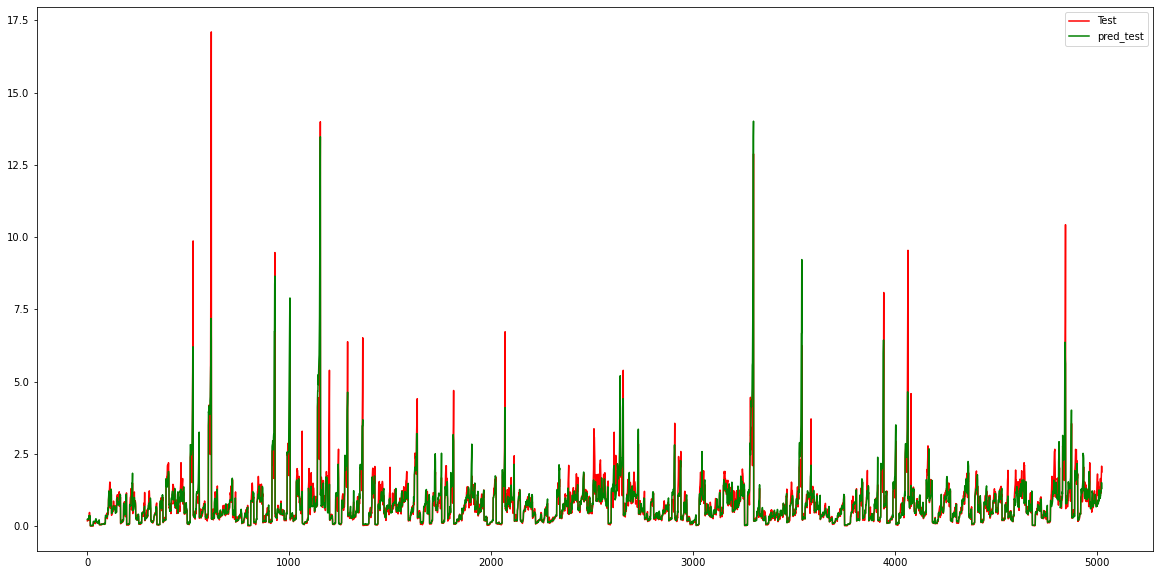

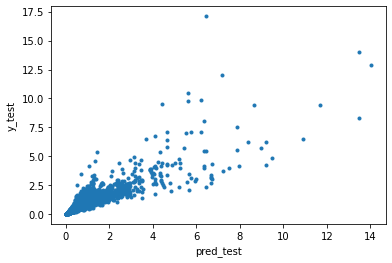

In [6]:
# from sklearn.ensemble import AdaBoostRegressor
# import matplotlib.pyplot as plt
# n = 200
# l = 1 #1.2
# lo = "square" 
# mi = 2
# ms = 1
# sp = "random"# best
# c = "mse"


# ada = AdaBoostRegressor(n_estimators=n,learning_rate=l,loss=lo,base_estimator=DecisionTreeRegressor(min_samples_split=mi,min_samples_leaf=ms,splitter=sp,criterion=c))
# ada.fit(X_train,y_train)

# pred_test = ada.predict(x_test)
# pred_test = pred_test.reshape(-1,1)
# sample_n = pred_test.shape[0]
# feature_n = x_test.shape[1]
# a0=calculate(y_test,pred_test,sample_n,feature_n)

# plt.figure(figsize=(20, 10))
# plt.plot(np.arange(1,len(y_test)+1),y_test, 'r-',label='Test')
# plt.plot(np.arange(1,len(pred_test)+1),pred_test, 'g-',label='pred_test')
# plt.legend(loc='best')
# plt.show()

# plt.xlabel('pred_test')
# plt.ylabel('y_test')
# plt.scatter(pred_test,y_test,marker='.')
# plt.show()